# 検証: エージェントにtoolとして別のエージェントを渡す

SubGraphの使い方: https://zenn.dev/pharmax/articles/148bc9497d68dd

- toolとして別のエージェントを使うことは可能か => 可能
- SubGraphなら、メインのGraphのmessagesが大きくなりすぎないで済むか => 設計によっては可能だが、バッチ処理っぽい感じになる
  - SubGraphをノードとして組み込むため、ある処理の後に必ず実行させる、というケースには有効
  - タスク内容から子エージェントの利用有無を動的に決定するような機能では、子エージェントの機能をtoolとして親エージェントに渡す必要がある
- 親エージェント側のmessagesは、子エージェントを使った設計では膨らまずに済むか => イエス

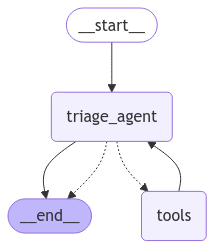

In [74]:
import json
from typing import Annotated, Literal, List, Optional, Dict
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from typing_extensions import TypedDict
from IPython.display import Image, display
from datetime import datetime, timedelta
import random
from operator import add

######## 関数の定義 
@tool
def fetch_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> List[dict]:
    """
    Fetch reviews from the JSON file based on the provided arguments.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        list: A list of filtered review objects.
    """

    mock_reviews = []
    if not categories:
        categories = ["雰囲気", "接客"]

    for i in range(limit):
        review_categories = random.sample(categories, k=min(len(categories), random.randint(1, 3)))
        review = {
            "store_id": store_id,
            "id": i + 1,
            "content": f"Mock review content for query '{query}' and category '{random.choice(categories)}'",
            "sentiment": sentiment,
            "categories": review_categories,
            "posted_at": (
                posted_at_from
                + timedelta(
                    days=random.randint(0, (posted_at_to - posted_at_from).days)
                )
            ).isoformat(),
        }
        mock_reviews.append(review)

    return mock_reviews

@tool
def fetch_categories() -> List[str]:
    """
    Fetch a list of predefined categories.

    Returns:
        list: A list of category strings.
    """
    return ["価格", "雰囲気", "接客", "品質"]

@tool
def fetch_store_ratings() -> Dict[int, float]:
    """
    Fetch store ratings for all stores.

    Returns:
        dict: A dictionary where keys are store IDs and values are ratings (1.0 to 5.0).
    """
    return {
        1: 1.3,
        2: 4.0,
        3: 1.0,
        4: 3.5,
        5: 3.6,
        6: 3.9,
        7: 3.5,
        8: 4.9,
        9: 3.4,
        10: 2.0,
    }

@tool
def fetch_sales_trends(store_id: int) -> Dict[str, int]:
    """
    Fetch monthly sales trends for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        dict: A dictionary where keys are months and values are sales numbers.
    """
    sales_trends = {}
    for month in range(1, 13):
        if month in [7, 8]:
            sales = random.randint(2000, 3000)  # 7~8月の売り上げが高い
        else:
            sales = random.randint(500, 1500)
        sales_trends[f"2024-{month:02d}"] = sales
    sales_trends["2025-01"] = random.randint(500, 1500)
    return sales_trends

######## 子グラフの定義 
# 口コミ取得の条件を与えると分析結果を返してくれるchatbot

review_analyzer_tools = [fetch_reviews]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
review_analyzer_llm = llm.bind_tools(review_analyzer_tools)

class ReviewAnalyzerState(TypedDict):
    messages: Annotated[List, add_messages]

def review_analyzer_agent(state: ReviewAnalyzerState):
    # こいつがノードの定義で使われるもの
    # 平たくいうとstateを受け取って、stateに追加したいものを返す関数
    response = review_analyzer_llm.invoke(state["messages"])
    return {"messages": [response]}

review_analyzer_builder = StateGraph(ReviewAnalyzerState)

review_analyzer_builder.add_node("analyzer", review_analyzer_agent)
review_analyzer_tool_node = ToolNode(tools=review_analyzer_tools)
review_analyzer_builder.add_node("tools", review_analyzer_tool_node)
review_analyzer_builder.add_conditional_edges("analyzer", tools_condition)
review_analyzer_builder.add_edge("tools", "analyzer")
review_analyzer_builder.set_entry_point("analyzer")
review_analyzer_builder.set_finish_point("analyzer")

review_agent = review_analyzer_builder.compile()

######## 呼び出し元(親graph)の定義 ##########
class State(TypedDict):
    messages: Annotated[List, add_messages]
    path: Annotated[list[str], add]

@tool
def analysis_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> str:
    """
    Retrieves store reviews based on the specified arguments and returns the analyzed results.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        str: Store review analysis data.
    """

    categories_str = ", ".join(categories) if categories else "None"
    formatted_str = (
        f"- store_id: {store_id}\n"
        f"- query: \"{query}\"\n"
        f"- posted_at_from: {posted_at_from}\n"
        f"- posted_at_to: {posted_at_to}\n"
        f"- limit: {limit}\n"
        f"- sentiment: \"{sentiment}\"\n"
        f"- categories: {categories_str}"
    )
    
    messages = [
        {
            "role": "user",
            "content": f"以下の条件で口コミを収集し、店舗改善案を作成してください。\n{formatted_str}"
        }
    ]
    response = review_agent.invoke({"messages": messages}, debug=False)

    return response["messages"][-1].content

# fetch_reviewの代わりにanalysis_reviewsを追加
tools = [analysis_reviews, fetch_categories, fetch_store_ratings, fetch_sales_trends]
triage_llm = llm.bind_tools(tools)


class State(TypedDict):
    messages: Annotated[List, add_messages]

def triage_agent(state: ReviewAnalyzerState):
    response = triage_llm.invoke(state["messages"])
    return {"messages": [response]}

triage_agent_builder = StateGraph(State)

triage_agent_builder.add_node("triage_agent", triage_agent)
parent_tool_node = ToolNode(tools=tools)
triage_agent_builder.add_node("tools", parent_tool_node)
triage_agent_builder.add_conditional_edges("triage_agent", tools_condition)
triage_agent_builder.add_edge("tools", "triage_agent")
triage_agent_builder.set_entry_point("triage_agent")
triage_agent_builder.set_finish_point("triage_agent")

triage_agent_builder.add_edge(START, "triage_agent")

triage_agent = triage_agent_builder.compile()

try:
    display(Image(triage_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Exception:", e)

In [75]:
cnt = 0
messages = (
                "user",
                "評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください",
            )
for response in triage_agent.stream({"messages": [messages]}, debug=False):
    cnt += 1
    print(f"Response {cnt}:")
    if response.get('triage_agent'):
        msg = response.get('triage_agent')["messages"][-1]
        msg.pretty_print()
    if response.get('tools'):
        msg = response.get('tools')["messages"][-1]
        msg.pretty_print()
    print("")

Response 1:
================================== Ai Message ==================================
Tool Calls:
  fetch_store_ratings (call_snBbg2QRyasSiW8yKN7xHJs2)
 Call ID: call_snBbg2QRyasSiW8yKN7xHJs2
  Args:

Response 2:
================================= Tool Message =================================
Name: fetch_store_ratings

{"1": 1.3, "2": 4.0, "3": 1.0, "4": 3.5, "5": 3.6, "6": 3.9, "7": 3.5, "8": 4.9, "9": 3.4, "10": 2.0}

Response 3:
================================== Ai Message ==================================
Tool Calls:
  fetch_sales_trends (call_GMbaimowSgvnqSC2N92Dy5yJ)
 Call ID: call_GMbaimowSgvnqSC2N92Dy5yJ
  Args:
    store_id: 8

Response 4:
================================= Tool Message =================================
Name: fetch_sales_trends

{"2024-01": 1465, "2024-02": 1063, "2024-03": 1160, "2024-04": 1147, "2024-05": 1056, "2024-06": 990, "2024-07": 2802, "2024-08": 2878, "2024-09": 1365, "2024-10": 809, "2024-11": 501, "2024-12": 791, "2025-01": 689}

Response 

## 最後のステップで実行されたAPIリクエストのmessagesを整形したもの

```
[
    {
        'content': '評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください',
        'role': 'user'
    },
    {
        'content': None,
        'role': 'assistant', 'tool_calls': [
            {'type': 'function', 'id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX', 'function': {'name': 'fetch_store_ratings', 'arguments': '{}'
                }
            }
        ]
    },
    {
        'content': '{
            "1": 1.3,
            "2": 4.0,
            "3": 1.0,
            "4": 3.5,
            "5": 3.6,
            "6": 3.9,
            "7": 3.5,
            "8": 4.9,
            "9": 3.4,
            "10": 2.0
        }',
        'role': 'tool', 'tool_call_id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX'
    },
    {
        'content': None,
        'role': 'assistant', 'tool_calls': [
            {'type': 'function', 'id': 'call_9Gq7bJdimdKPvs9O7Qw75yPz', 'function': {'name': 'fetch_sales_trends', 'arguments': '{
                        "store_id": 8
                    }'
                }
            }
        ]
    },
    {
        'content': '{
            "2024-01": 736,
            "2024-02": 735,
            "2024-03": 1085,
            "2024-04": 761,
            "2024-05": 1005,
            "2024-06": 1347,
            "2024-07": 2220,
            "2024-08": 2025,
            "2024-09": 822,
            "2024-10": 1357,
            "2024-11": 639,
            "2024-12": 613,
            "2025-01": 932
        }',
        'role': 'tool', 'tool_call_id': 'call_9Gq7bJdimdKPvs9O7Qw75yPz'
    },
    {
        'content': None,
        'role': 'assistant', 'tool_calls': [
            {'type': 'function', 'id': 'call_Q2zuOYPsSrSvM1zBoSJfB7er', 'function': {'name': 'analysis_reviews', 'arguments': '{
                        "store_id": 8,
                        "query": "\\u6599\\u7406",
                        "posted_at_from": "2024-06-01T00:00:00",
                        "posted_at_to": "2024-08-31T23:59:59",
                        "limit": 10,
                        "sentiment": "positive"
                    }'
                }
            }
        ]
    },
    {
        'content': '以下は、2024年6月1日から2024年8月31日までの期間に収集した、店舗ID 8に関する「料理」に関するポジティブな口コミの要約です。\n\n### 収集した口コミの要約\n1. **雰囲気と接客**: 多くの口コミで、店舗の雰囲気や接客が高く評価されています。特に、スタッフの対応が良いと感じているお客様が多いです。\n2. **料理の質**: 具体的な料理の内容についての言及は少ないものの、全体的に料理に対する満足度が高い印象を受けます。\n3. **リピート意向**: ポジティブな口コミからは、再訪したいという意向が伺えます。\n\n### 店舗改善案\n1. **料理メニューの強化**: 口コミには料理の具体的な内容が少ないため、特に人気のある料理や新メニューを強調するプロモーションを行うことを検討してください。\n2. **接客トレーニングの継続**: 既に高評価の接客をさらに向上させるため、定期的な接客トレーニングを実施し、スタッフのモチベーションを維持しましょう。\n3. **雰囲気の維持・向上**: 雰囲気が好評であるため、店舗のインテリアや音楽、照明などを定期的に見直し、常に快適な空間を提供できるように心掛けましょう。\n4. **顧客フィードバックの活用**: 定期的に顧客からのフィードバックを収集し、改善点や新しいアイデアを取り入れることで、顧客満足度をさらに向上させることができます。\n\nこれらの改善案を実施することで、さらなる顧客満足度の向上が期待できるでしょう。',
        'role': 'tool', 'tool_call_id': 'call_Q2zuOYPsSrSvM1zBoSJfB7er'
    }
]
```

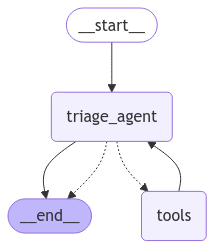

In [1]:
import json
from typing import Annotated, Literal, List, Optional, Dict
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from typing_extensions import TypedDict
from IPython.display import Image, display
from datetime import datetime, timedelta
import random
from operator import add

######## 関数の定義 
@tool
def fetch_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> List[dict]:
    """
    Fetch reviews from the JSON file based on the provided arguments.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        list: A list of filtered review objects.
    """

    mock_reviews = []
    if not categories:
        categories = ["雰囲気", "接客"]

    for i in range(limit):
        review_categories = random.sample(categories, k=min(len(categories), random.randint(1, 3)))
        review = {
            "store_id": store_id,
            "id": i + 1,
            "content": f"Mock review content for query '{query}' and category '{random.choice(categories)}'",
            "sentiment": sentiment,
            "categories": review_categories,
            "posted_at": (
                posted_at_from
                + timedelta(
                    days=random.randint(0, (posted_at_to - posted_at_from).days)
                )
            ).isoformat(),
        }
        mock_reviews.append(review)

    return mock_reviews

@tool
def fetch_categories() -> List[str]:
    """
    Fetch a list of predefined categories.

    Returns:
        list: A list of category strings.
    """
    return ["価格", "雰囲気", "接客", "品質"]

@tool
def fetch_store_ratings() -> Dict[int, float]:
    """
    Fetch store ratings for all stores.

    Returns:
        dict: A dictionary where keys are store IDs and values are ratings (1.0 to 5.0).
    """
    return {
        1: 1.3,
        2: 4.0,
        3: 1.0,
        4: 3.5,
        5: 3.6,
        6: 3.9,
        7: 3.5,
        8: 4.9,
        9: 3.4,
        10: 2.0,
    }

@tool
def fetch_sales_trends(store_id: int) -> Dict[str, int]:
    """
    Fetch monthly sales trends for a specific store.

    Args:
        store_id (int): The store ID.

    Returns:
        dict: A dictionary where keys are months and values are sales numbers.
    """
    sales_trends = {}
    for month in range(1, 13):
        if month in [7, 8]:
            sales = random.randint(2000, 3000)  # 7~8月の売り上げが高い
        else:
            sales = random.randint(500, 1500)
        sales_trends[f"2024-{month:02d}"] = sales
    sales_trends["2025-01"] = random.randint(500, 1500)
    return sales_trends

######## 子グラフの定義 
# 口コミ取得の条件を与えると分析結果を返してくれるchatbot

review_analyzer_tools = [fetch_reviews]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
review_analyzer_llm = llm.bind_tools(review_analyzer_tools)

class ReviewAnalyzerState(TypedDict):
    messages: Annotated[List, add_messages]

def review_analyzer_agent(state: ReviewAnalyzerState):
    # こいつがノードの定義で使われるもの
    # 平たくいうとstateを受け取って、stateに追加したいものを返す関数
    response = review_analyzer_llm.invoke(state["messages"])
    return {"messages": [response]}

review_analyzer_builder = StateGraph(ReviewAnalyzerState)

review_analyzer_builder.add_node("analyzer", review_analyzer_agent)
review_analyzer_tool_node = ToolNode(tools=review_analyzer_tools)
review_analyzer_builder.add_node("tools", review_analyzer_tool_node)
review_analyzer_builder.add_conditional_edges("analyzer", tools_condition)
review_analyzer_builder.add_edge("tools", "analyzer")
review_analyzer_builder.set_entry_point("analyzer")
review_analyzer_builder.set_finish_point("analyzer")

review_agent = review_analyzer_builder.compile()

######## 呼び出し元(親graph)の定義 ##########
class State(TypedDict):
    messages: Annotated[List, add_messages]
    path: Annotated[list[str], add]

@tool
def analysis_reviews(
    store_id: int,
    query: str,
    posted_at_from: datetime,
    posted_at_to: datetime,
    limit: int,
    sentiment: Literal["positive", "negative"],
    categories: Optional[List[str]] = [],
) -> str:
    """
    Retrieves store reviews based on the specified arguments and returns the analyzed results.

    Args:
        store_id (int): The store ID.
        query (str): The search query.
        posted_at_from (datetime): The start of the date range.
        posted_at_to (datetime): The end of the date range.
        categories (list, optional): List of categories to filter by. Defaults to None.
        limit (int): Maximum number of reviews to fetch.
        sentiment (Literal['positive', 'negative']): Filter reviews by sentiment.

    Returns:
        str: Store review analysis data.
    """

    categories_str = ", ".join(categories) if categories else "None"
    formatted_str = (
        f"- store_id: {store_id}\n"
        f"- query: \"{query}\"\n"
        f"- posted_at_from: {posted_at_from}\n"
        f"- posted_at_to: {posted_at_to}\n"
        f"- limit: {limit}\n"
        f"- sentiment: \"{sentiment}\"\n"
        f"- categories: {categories_str}"
    )
    
    messages = [
        {
            "role": "user",
            "content": f"以下の条件で口コミを収集し、店舗改善案を作成してください。\n{formatted_str}"
        }
    ]
    response = review_agent.invoke({"messages": messages}, debug=False)

    return response["messages"][-1].content

# fetch_reviewの代わりにanalysis_reviewsを追加
tools = [analysis_reviews, fetch_categories, fetch_store_ratings, fetch_sales_trends]
triage_llm = llm.bind_tools(tools)


class State(TypedDict):
    messages: Annotated[List, add_messages]

def triage_agent(state: ReviewAnalyzerState):
    response = triage_llm.invoke(state["messages"])
    return {"messages": [response]}

triage_agent_builder = StateGraph(State)

triage_agent_builder.add_node("triage_agent", triage_agent)
parent_tool_node = ToolNode(tools=tools)
triage_agent_builder.add_node("tools", parent_tool_node)
triage_agent_builder.add_conditional_edges("triage_agent", tools_condition)
triage_agent_builder.add_edge("tools", "triage_agent")
triage_agent_builder.set_entry_point("triage_agent")
triage_agent_builder.set_finish_point("triage_agent")

triage_agent_builder.add_edge(START, "triage_agent")

triage_agent = triage_agent_builder.compile()

try:
    display(Image(triage_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Exception:", e)

In [4]:
cnt = 0
messages = [(
                "user",
                "評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください",
            )]
result = triage_agent.invoke({"messages": messages}, debug=False)
result

client.chat.completions.create
messages:
[{'content': '評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください', 'role': 'user'}]
client.chat.completions.create
messages:
[{'content': '評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください', 'role': 'user'}, {'content': None, 'role': 'assistant', 'tool_calls': [{'type': 'function', 'id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX', 'function': {'name': 'fetch_store_ratings', 'arguments': '{}'}}]}, {'content': '{"1": 1.3, "2": 4.0, "3": 1.0, "4": 3.5, "5": 3.6, "6": 3.9, "7": 3.5, "8": 4.9, "9": 3.4, "10": 2.0}', 'role': 'tool', 'tool_call_id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX'}]
client.chat.completions.create
messages:
[{'content': '評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください', 'role': 'user'}, {'content': None, 'role': 'assistant', 'tool_calls': [{'type': 'function', 'id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX', 'function': {'name': 'fetch_store_ratings', 'arguments': '{}'}}]}, {'content': '{"1": 1.3, "2": 4.0, "3": 1.0, "4": 3

{'messages': [HumanMessage(content='評価の高い店舗の売り上げを分析し、特に売り上げが高かった時期の料理に関する口コミを収集し、高評価の要因を予測してください', additional_kwargs={}, response_metadata={}, id='52d8a11a-101d-4800-a089-690516a4141b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX', 'function': {'arguments': '{}', 'name': 'fetch_store_ratings'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 369, 'total_tokens': 382, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-00788625-39af-4548-ac6b-2f8ed6c74a45-0', tool_calls=[{'name': 'fetch_store_ratings', 'args': {}, 'id': 'call_EpwgOTOgXDJbSqQ7gx2u57zX', 'type': 'tool_call'}], usage_